In [1]:
import pandas as pd
import numpy as np
from astropy.io import fits
import math
import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from astropy.coordinates import Galactic
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO
pointing_5_E2 = pd.read_csv('pointing_5_E2 copy 2.csv')
plt.scatter(pointing_5_E2['magnitude_als_814'],pointing_5_E2['magnitude_als_814']-pointing_5_E2['magnitude_ap_814'])
plt.axhline(.025)
plt.ylim(-.2,.2)

(-0.2, 0.2)

In [2]:
#new ap corr
#pointing_5_E2 = pd.read_csv('pointing_5_E2 copy 2.csv')
pointing_5_E2['MAG_psf_f606w'] = pointing_5_E2['magnitude_als_606'] + 0.08 + 2.5*np.log10(0.904) + 2.5*np.log10(9792) - 25 + 26.403
pointing_5_E2['MAG_psf_f814w'] = (pointing_5_E2['magnitude_als_814'] - 0.02 + 2.5*np.log10(0.901) + 2.5*np.log10(10064) - 25 + 25.514)
pointing_5_E2.to_csv('pointing_5_E2.csv')

# Plots for 606, matching aperture results to Allstar results to get magnitudes

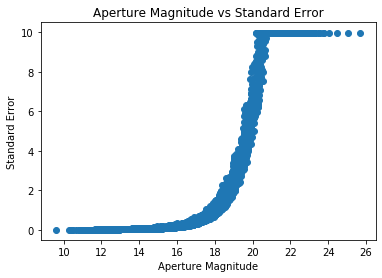

In [3]:
with open('pointing_5_606_mask.ap', 'r') as in_file:
    contents = in_file.read().replace('\n\n', ',')

ap_data_606 = pd.read_csv(StringIO(contents), sep='\s+',
                 names=['ID', 'x', 'y', 'magnitude','sky','sky std','sky skew', 'standard error'],
                 lineterminator=',',
                 skipinitialspace=True,
                 header=None, skiprows=2)
ap_data_606_clean = ap_data_606[ap_data_606['magnitude'] < 99]
ap_data_606 = ap_data_606.set_index('ID')

plt.title('Aperture Magnitude vs Standard Error')
plt.xlabel('Aperture Magnitude')
plt.ylabel('Standard Error')
plt.scatter(x = ap_data_606_clean['magnitude'], y = ap_data_606_clean['standard error'])
plt.show()

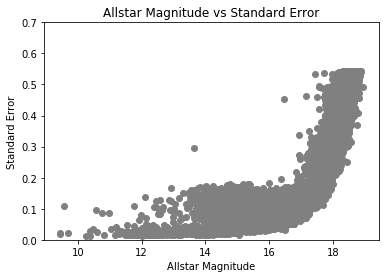

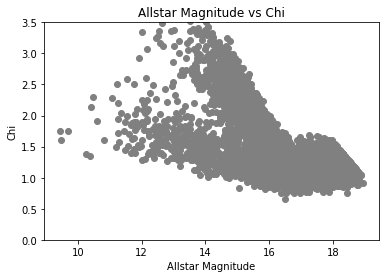

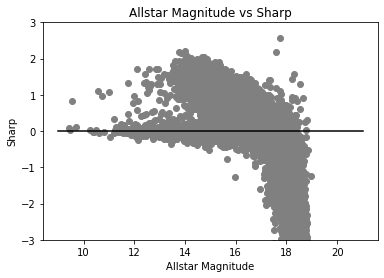

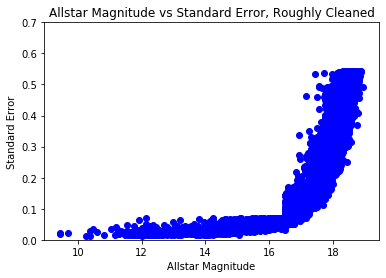

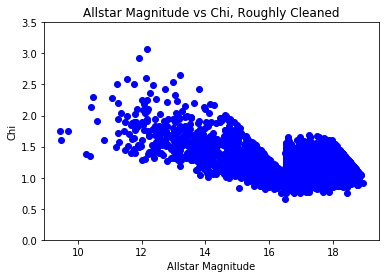

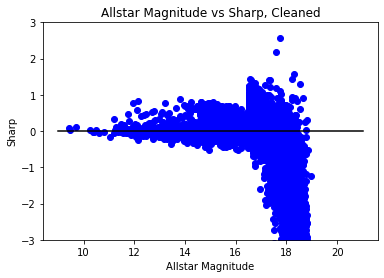

In [4]:
#reading in allstar data
als_data_606 = pd.read_csv('pointing_5_606_mask.als', sep='\s+', header=None, skiprows=2, 
                  names = ['ID', 'x', 'y', 'magnitude', 'standard error', 'sky', 'iterations', 'chi', 'sharp'])
als_data_606 = als_data_606.set_index('ID')

als_data_606 = als_data_606[als_data_606['magnitude']>9.4] #stars below here are ridiculously overexposed

als_data_606_rough_clean = als_data_606[(als_data_606['standard error']< .07) & (als_data_606['magnitude']<16.5) 
                                  | (als_data_606['magnitude']>16.5)]

plt.title('Allstar Magnitude vs Standard Error')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Standard Error')
plt.ylim(0,.7)
plt.scatter(x = als_data_606['magnitude'], y = als_data_606['standard error'],color='grey')
plt.show()

plt.title('Allstar Magnitude vs Chi')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Chi')
plt.ylim(0,3.5)
plt.scatter(x = als_data_606['magnitude'], y = np.sqrt(als_data_606['chi']), color='grey')
plt.show()

plt.title('Allstar Magnitude vs Sharp')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Sharp')
plt.ylim(-3,3)
plt.scatter(x = als_data_606['magnitude'], y = als_data_606['sharp'], color='grey')
plt.plot([9,21], [0, 0], 'k-')
plt.show()


#post very rough cuts !
plt.title('Allstar Magnitude vs Standard Error, Roughly Cleaned')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Standard Error')
plt.ylim(0,.7)
plt.scatter(x = als_data_606_rough_clean['magnitude'], y = als_data_606_rough_clean['standard error'], color='blue')
plt.show()

plt.title('Allstar Magnitude vs Chi, Roughly Cleaned')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Chi')
plt.ylim(0,3.5)
plt.scatter(x = als_data_606_rough_clean['magnitude'], y = np.sqrt(als_data_606_rough_clean['chi']), color='blue')
plt.show()


plt.title('Allstar Magnitude vs Sharp, Cleaned')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Sharp')
plt.ylim(-3,3)
plt.scatter(x = als_data_606_rough_clean['magnitude'], y = als_data_606_rough_clean['sharp'], color='blue')
plt.plot([9,21], [0, 0], 'k-')
plt.show()

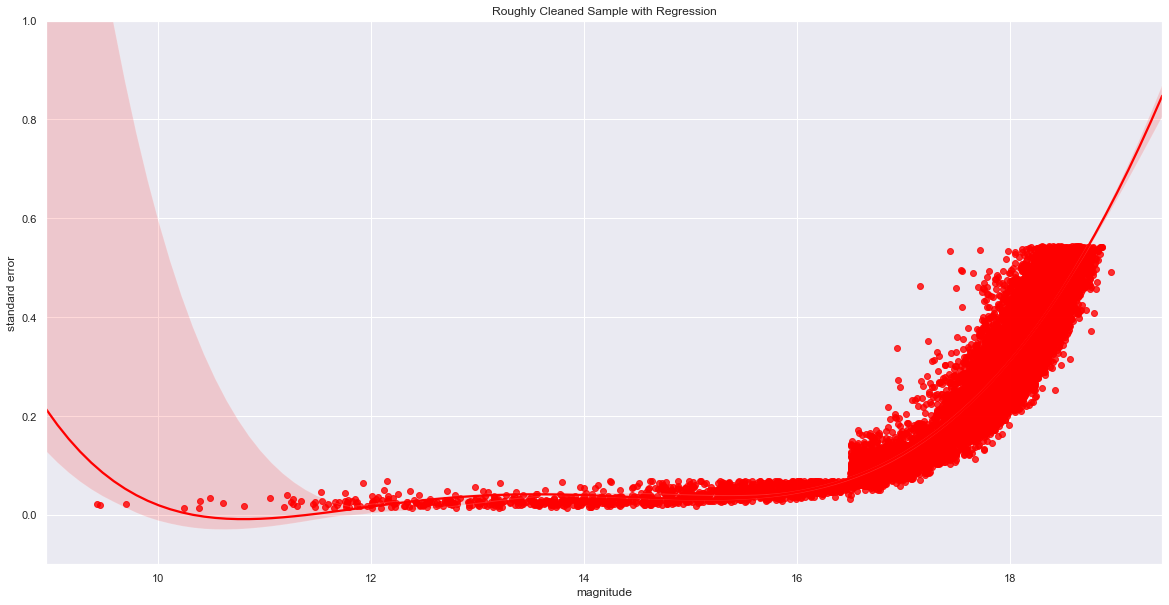

R^2 coefficient 0.869807877931765
coefficients: [[-4.19543881e+00  5.07917141e-01 -2.69656055e-02  5.30579496e-04]]


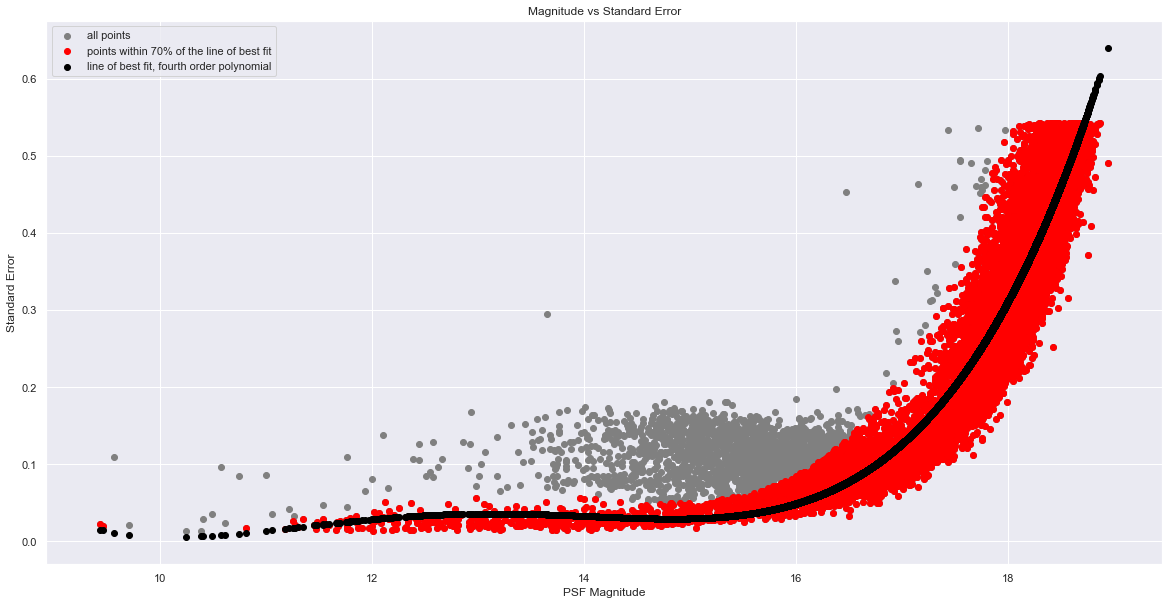

In [5]:
#attempting to get a line of best fit to then define quality cuts off of - note that I need to make the crude cut 
#above first to avoid having the noisey/bad data weight the fit, this way i fit only the ~good~ data

#http://seaborn.pydata.org/generated/seaborn.regplot.html?highlight=regplot#seaborn.regplot
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(20,10))
plt.title('Roughly Cleaned Sample with Regression')
plt.ylim(-0.1,1)
ax = sns.regplot(x="magnitude", y="standard error", data=als_data_606_rough_clean, color='red', order=5, fit_reg=True,
                 ci=100)
plt.show()


#following this to get equation of regression line https://realpython.com/linear-regression-in-python/ 
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
x=als_data_606_rough_clean["magnitude"]
y = als_data_606_rough_clean['standard error']

x = np.array([x]).reshape(-1,1)
x_ = PolynomialFeatures(degree=4, include_bias=False).fit_transform(x) #getting it so that it will do polynomial
#order five fit
y = np.array([y]).reshape(-1,1)
model = LinearRegression().fit(x_, y)
r_sq = model.score(x_, y)
coefficients = model.coef_
print('R^2 coefficient',r_sq)
print('coefficients:', model.coef_)



#equation of our regression line
x = als_data_606['magnitude']
y = als_data_606['standard error']

regression_line = np.array([coefficients[:,0]*x**1 + coefficients[:,1]*x**2 + coefficients[:,2]*x**3 + 
                            coefficients[:,3]*x**4 + model.intercept_]).reshape(14122,)



#cutting data using buffer around regression line
#als_data_606_clean = als_data_606[(y < 1.682*regression_line) & (y > 0.318*regression_line)]
als_data_606_clean = als_data_606[(y < 1.75*abs(regression_line)) & (y > 0.25*abs(regression_line))] 
#abs bc line goes neg

plt.figure(figsize=(20,10))
plt.title('Magnitude vs Standard Error')
plt.scatter(x, y, color='grey')
plt.scatter(als_data_606_clean['magnitude'], als_data_606_clean['standard error'], color='red',marker='o')
plt.scatter(x, regression_line, color='black')
plt.legend(['all points', 'points within 70% of the line of best fit',
            'line of best fit, fourth order polynomial'])
plt.ylabel('Standard Error')
plt.xlabel('PSF Magnitude')
plt.show()

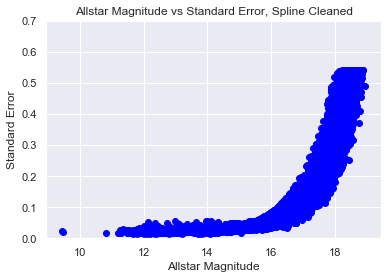

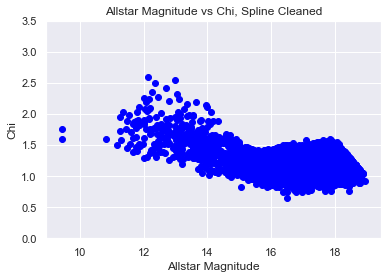

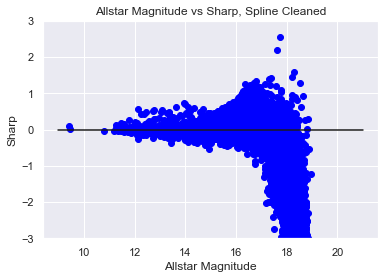

In [6]:
#post clean cuts !
plt.title('Allstar Magnitude vs Standard Error, Spline Cleaned')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Standard Error')
plt.ylim(0,.7)
plt.scatter(x = als_data_606_clean['magnitude'], y = als_data_606_clean['standard error'], color='blue')
plt.show()

plt.title('Allstar Magnitude vs Chi, Spline Cleaned')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Chi')
plt.ylim(0,3.5)
plt.scatter(x = als_data_606_clean['magnitude'], y = np.sqrt(als_data_606_clean['chi']), color='blue')
plt.show()


plt.title('Allstar Magnitude vs Sharp, Spline Cleaned')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Sharp')
plt.ylim(-3,3)
plt.scatter(x = als_data_606_clean['magnitude'], y = als_data_606_clean['sharp'], color='blue')
plt.plot([9,21], [0, 0], 'k-')
plt.show()

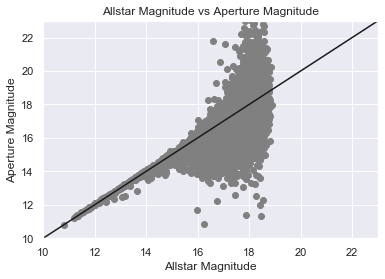

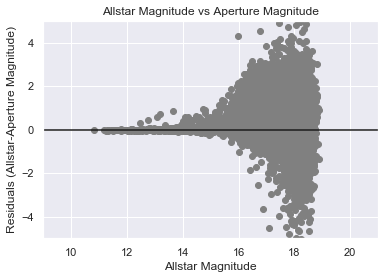

In [7]:
#combining data sets, one clean, one uncleaned
data_606_clean = pd.merge(ap_data_606, als_data_606_clean, how='inner', left_on=['ID'], right_on=['ID'], 
                    suffixes=['_ap','_als'])
data_606_clean = data_606_clean[data_606_clean['magnitude_ap']<99]

#uncleaned - this is so we can clean first and second run together later
data_606 = pd.merge(als_data_606, ap_data_606, how='inner', left_on=['ID'], right_on=['ID'], 
                    suffixes=['_als','_ap'])


#seeing how als compares to ap
plt.title('Allstar Magnitude vs Aperture Magnitude')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Aperture Magnitude')
plt.xlim(10,23)
plt.ylim(10, 23)
plt.scatter(x = data_606_clean['magnitude_als'], y = data_606_clean['magnitude_ap'], color='grey')
plt.plot([10, 23], [10, 23], 'k-')
plt.show()

#plotting residuals
plt.title('Allstar Magnitude vs Aperture Magnitude')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Residuals (Allstar-Aperture Magnitude)')
plt.ylim(-5, 5)
plt.xlim(9,21)
plt.scatter(x = data_606_clean['magnitude_als'], 
            y = data_606_clean['magnitude_als'] - data_606_clean['magnitude_ap'], color='grey')
plt.plot([9,21], [0, 0], 'k-')
plt.show()


# Same as above but for 814

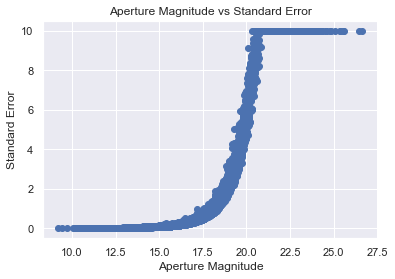

In [8]:
with open('pointing_5_814_mask.ap', 'r') as in_file:
    contents = in_file.read().replace('\n\n', ',')

ap_data_814 = pd.read_csv(StringIO(contents), sep='\s+',
                 names=['ID', 'x', 'y', 'magnitude','sky','sky std','sky skew', 'standard error'],
                 lineterminator=',',
                 skipinitialspace=True,
                 header=None, skiprows=2)
ap_data_814_clean = ap_data_814[ap_data_814['magnitude']<99]
ap_data_814 = ap_data_814.set_index('ID')

plt.title('Aperture Magnitude vs Standard Error')
plt.xlabel('Aperture Magnitude')
plt.ylabel('Standard Error')
plt.scatter(x = ap_data_814_clean['magnitude'], y = ap_data_814_clean['standard error'])
plt.show()

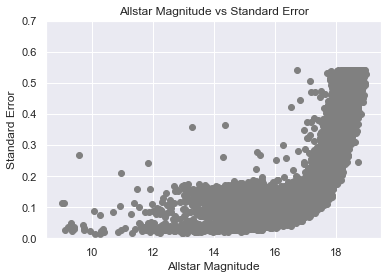

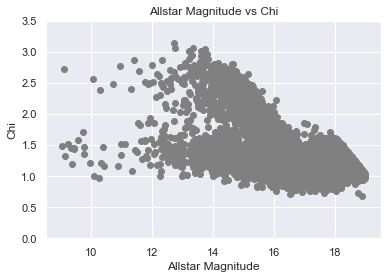

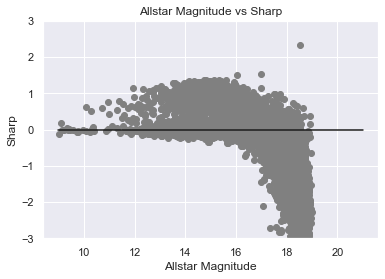

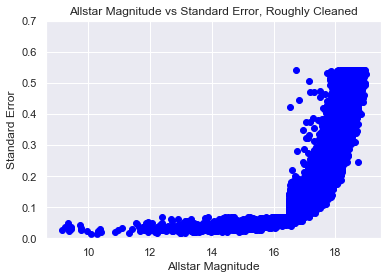

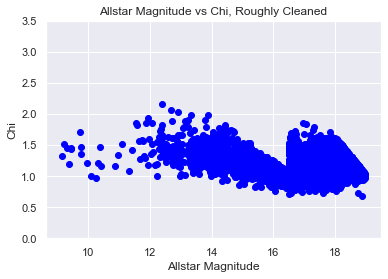

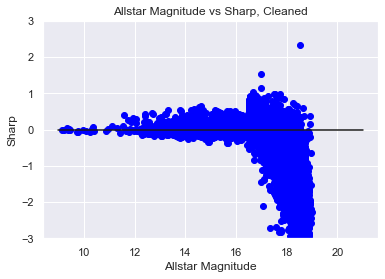

In [9]:
#reading in allstar data
als_data_814 = pd.read_csv('pointing_5_814_mask.als', sep='\s+', header=None, skiprows=2, 
                  names = ['ID', 'x', 'y', 'magnitude', 'standard error', 'sky', 'iterations', 'chi', 'sharp'])
als_data_814 = als_data_814.set_index('ID')
als_data_814 = als_data_814[als_data_814['magnitude']> 9.]

als_data_814_rough_clean = als_data_814[(als_data_814['standard error'] < 0.07) & (als_data_814['magnitude']<16.5) 
                                  | (als_data_814['magnitude']>16.5)]

plt.title('Allstar Magnitude vs Standard Error')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Standard Error')
plt.ylim(0,.7)
plt.scatter(x = als_data_814['magnitude'], y = als_data_814['standard error'],color='grey')
plt.show()

plt.title('Allstar Magnitude vs Chi')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Chi')
plt.ylim(0,3.5)
plt.scatter(x = als_data_814['magnitude'], y = np.sqrt(als_data_814['chi']), color='grey')
plt.show()

plt.title('Allstar Magnitude vs Sharp')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Sharp')
plt.ylim(-3,3)
plt.scatter(x = als_data_814['magnitude'], y = als_data_814['sharp'], color='grey')
plt.plot([9,21], [0, 0], 'k-')
plt.show()


#post very rough cuts !
plt.title('Allstar Magnitude vs Standard Error, Roughly Cleaned')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Standard Error')
plt.ylim(0,.7)
plt.scatter(x = als_data_814_rough_clean['magnitude'], y = als_data_814_rough_clean['standard error'], color='blue')
plt.show()

plt.title('Allstar Magnitude vs Chi, Roughly Cleaned')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Chi')
plt.ylim(0,3.5)
plt.scatter(x = als_data_814_rough_clean['magnitude'], y = np.sqrt(als_data_814_rough_clean['chi']), color='blue')
plt.show()


plt.title('Allstar Magnitude vs Sharp, Cleaned')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Sharp')
plt.ylim(-3,3)
plt.scatter(x = als_data_814_rough_clean['magnitude'], y = als_data_814_rough_clean['sharp'], color='blue')
plt.plot([9,21], [0, 0], 'k-')
plt.show()

#try cutting chi at  or so and then make cmd

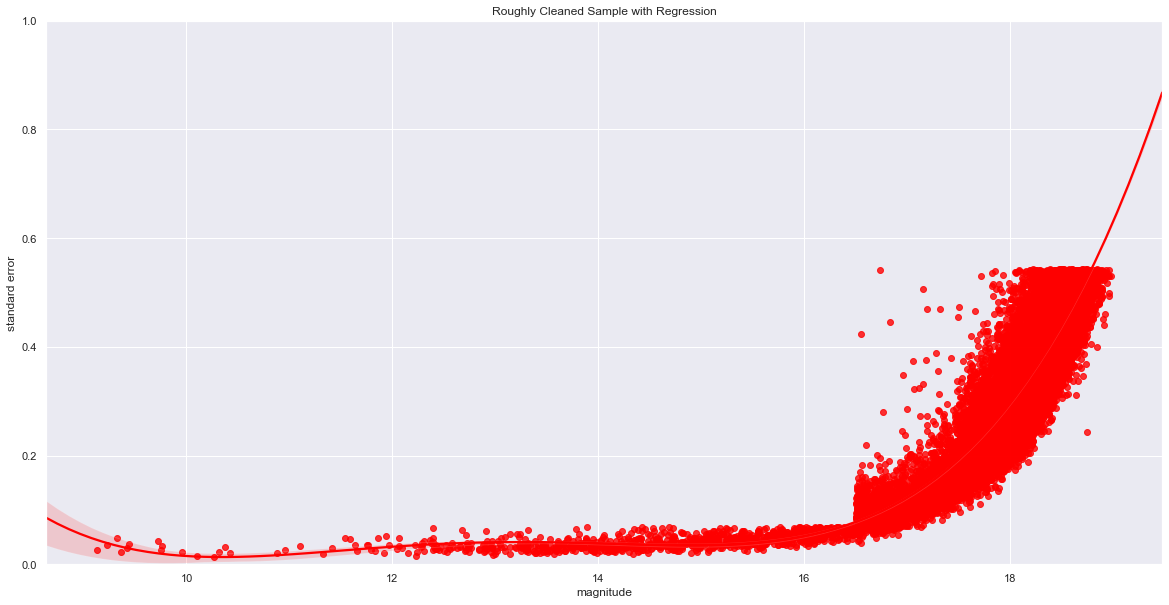

R^2 coefficient 0.8260760352754528
coefficients: [[-4.38473572e+00  5.24593811e-01 -2.75546510e-02  5.36907785e-04]]


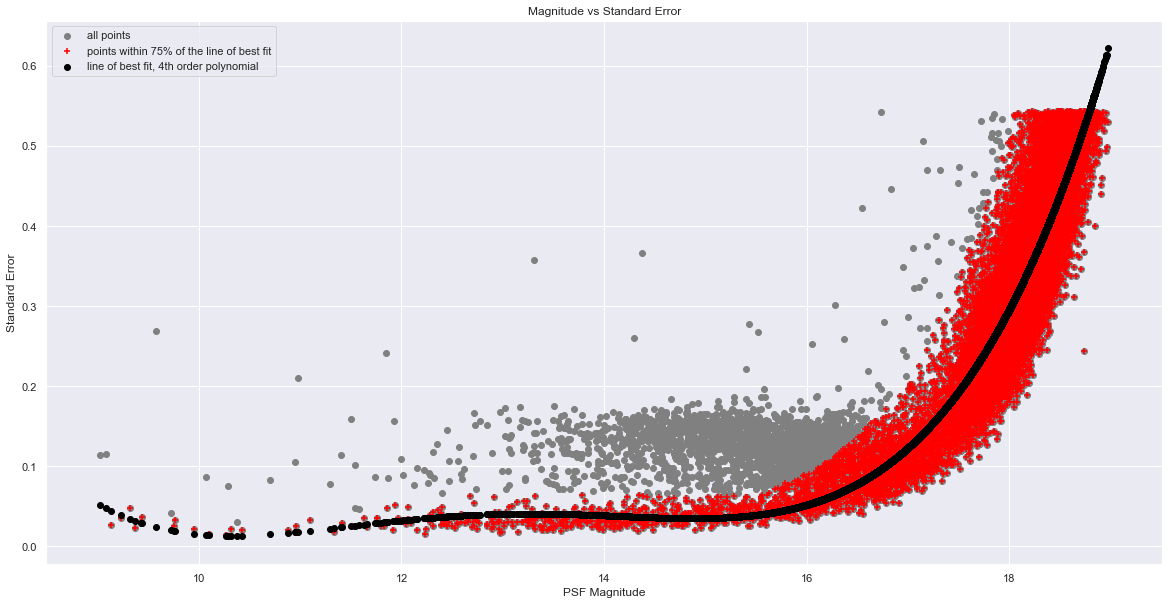

0.13812086626918063

In [10]:
#attempting to get a line of best fit to then define quality cuts off of - note that I need to make the crude cut 
#above first to avoid having the noisey/bad data weight the fit, this way i fit only the ~good~ data

#http://seaborn.pydata.org/generated/seaborn.regplot.html?highlight=regplot#seaborn.regplot
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(20,10))
plt.title('Roughly Cleaned Sample with Regression')
plt.ylim(0,1)
ax = sns.regplot(x="magnitude", y="standard error", data=als_data_814_rough_clean, color='red', order=4, fit_reg=True,
                 ci=100)
plt.show()


#following this to get equation of regression line https://realpython.com/linear-regression-in-python/ 
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
x=als_data_814_rough_clean["magnitude"]
y = als_data_814_rough_clean['standard error']

x = np.array([x]).reshape(-1,1)
x_ = PolynomialFeatures(degree=4, include_bias=False).fit_transform(x) #getting it so that it will do polynomial
#order five fit
y = np.array([y]).reshape(-1,1)
model = LinearRegression().fit(x_, y)
r_sq = model.score(x_, y)
coefficients = model.coef_
print('R^2 coefficient',r_sq)
print('coefficients:', model.coef_)

#equation of our regression line
x = als_data_814['magnitude']
y = als_data_814['standard error']

regression_line = np.array([coefficients[:,0]*x**1 + coefficients[:,1]*x**2 + coefficients[:,2]*x**3 + 
                            coefficients[:,3]*x**4 + model.intercept_]).reshape(21095,)

#cutting data using buffer around regression line
als_data_814_clean = als_data_814[(y < 1.75*abs(regression_line)) & (y > 0.25*abs(regression_line))]


plt.figure(figsize=(20,10))
plt.title('Magnitude vs Standard Error')
plt.scatter(x, y, color='grey')
plt.scatter(als_data_814_clean['magnitude'], als_data_814_clean['standard error'], color='red',marker='+')
plt.scatter(x, regression_line, color='black')
plt.legend(['all points', 'points within 75% of the line of best fit',
            'line of best fit, 4th order polynomial'])
plt.ylabel('Standard Error')
plt.xlabel('PSF Magnitude')
plt.show()

regression_line.std()


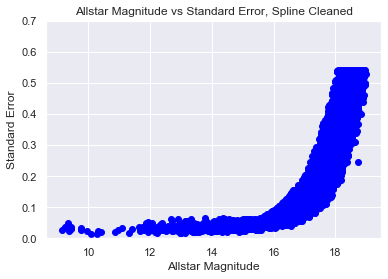

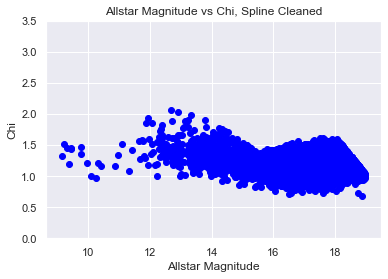

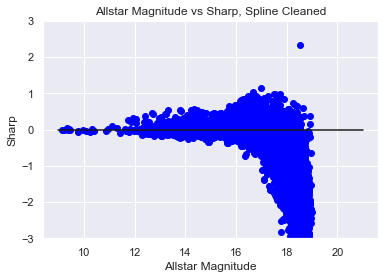

In [11]:
#post clean cuts !
plt.title('Allstar Magnitude vs Standard Error, Spline Cleaned')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Standard Error')
plt.ylim(0,.7)
plt.scatter(x = als_data_814_clean['magnitude'], y = als_data_814_clean['standard error'], color='blue')
plt.show()

plt.title('Allstar Magnitude vs Chi, Spline Cleaned')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Chi')
plt.ylim(0,3.5)
plt.scatter(x = als_data_814_clean['magnitude'], y = np.sqrt(als_data_814_clean['chi']), color='blue')
plt.show()


plt.title('Allstar Magnitude vs Sharp, Spline Cleaned')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Sharp')
plt.ylim(-3,3)
plt.scatter(x = als_data_814_clean['magnitude'], y = als_data_814_clean['sharp'], color='blue')
plt.plot([9,21], [0, 0], 'k-')
plt.show()

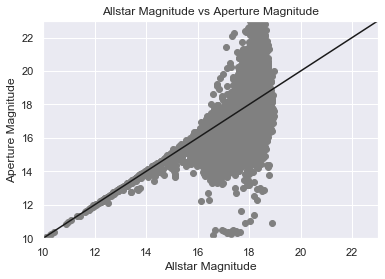

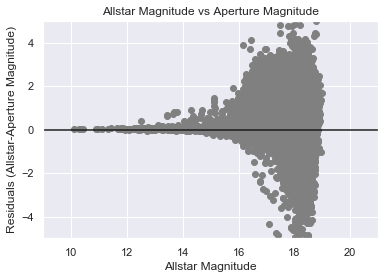

In [12]:
#combining data sets, one clean, one uncleaned
data_814_clean = pd.merge(ap_data_814, als_data_814_clean, how='inner', left_on=['ID'], right_on=['ID'], 
                    suffixes=['_ap','_als'])
data_814_clean = data_814_clean[data_814_clean['magnitude_ap']<99]

#uncleaned - this is so we can clean first and second run together later
data_814 = pd.merge(ap_data_814, als_data_814, how='inner', left_on=['ID'], right_on=['ID'], 
                    suffixes=['_ap','_als'])


#seeing how als compares to ap
plt.title('Allstar Magnitude vs Aperture Magnitude')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Aperture Magnitude')
plt.xlim(10,23)
plt.ylim(10, 23)
plt.scatter(x = data_814_clean['magnitude_als'], y = data_814_clean['magnitude_ap'], color='grey')
plt.plot([10, 23], [10, 23], 'k-')
plt.show()

#plotting residuals
plt.title('Allstar Magnitude vs Aperture Magnitude')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Residuals (Allstar-Aperture Magnitude)')
plt.ylim(-5, 5)
plt.xlim(9,21)
plt.scatter(x = data_814_clean['magnitude_als'], 
            y = data_814_clean['magnitude_als'] - data_814_clean['magnitude_ap'], color='grey')
plt.plot([9,21], [0, 0], 'k-')
plt.show()

# Colour magnitude diagrams from the first run of daophot - these DO NOT include results from finding stars in the second using the subtracted images! Those are in a separate notebook! Note also that these matches are using the spline cleaned ALLSTAR data, and AP mag < 99, hence reduction of bad points/noise.

        Use astropy.visualization.hist instead. [warnings]


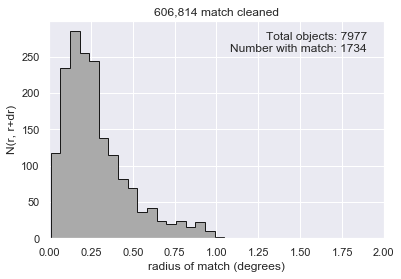

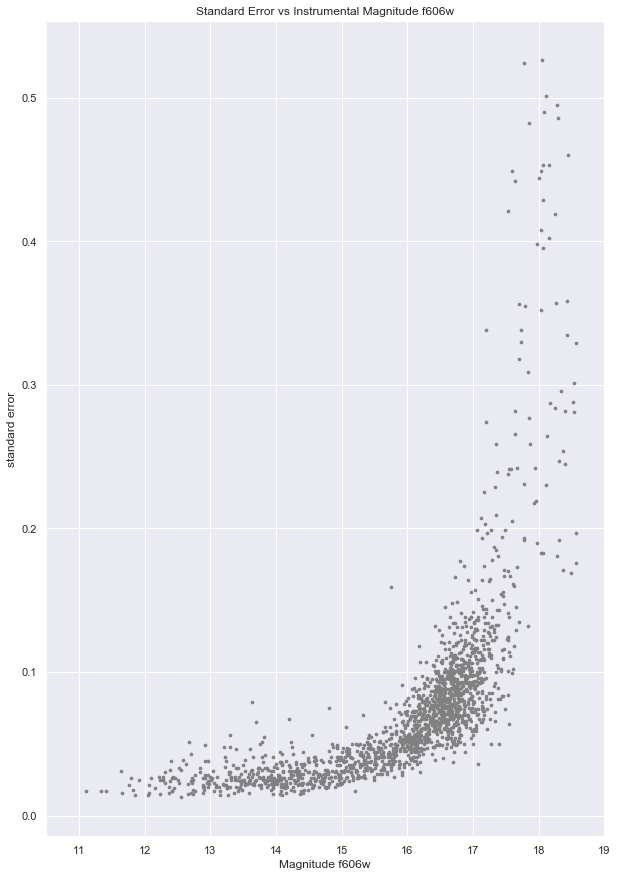

In [13]:
#exporting to csv files so that I can use topcat to cross match! 
data_606.to_csv('data_5_606.csv', encoding='utf-8', index=False)
data_814.to_csv('data_5_814.csv', encoding='utf-8', index=False)

#data_topcat = pd.read_csv('data') #seeing cross match from topcat



#doing a crossmatch with astroML, good sanity check that these are the same
import numpy as np
from matplotlib import pyplot as plt
from astroML.crossmatch import crossmatch
from astroML.plotting import hist

#this is NOT cleaned !
# defining an array that's len(data_606) x 2 then putting the x, y data into it 
imX = np.empty((len(data_606_clean), 2), dtype=np.float64)
imX[:, 0] = data_606_clean['x_als']
imX[:, 1] = data_606_clean['y_als']

# defining an array that's len(data_814) x 2 then putting the x, y data into it 
stX = np.empty((len(data_814_clean), 2), dtype=np.float64)
stX[:, 0] = data_814_clean['x_als']
stX[:, 1] = data_814_clean['y_als']




# crossmatch catalogs using https://www.astroml.org/book_figures/chapter6/fig_stellar_XD.html
max_radius = 1  # the # of maximum degrees in separation
dist, ind = crossmatch(imX, stX, max_radius)
match = (~np.isinf(dist))
dist_match = dist[match]
match_ind = ind[match]




ax = plt.axes()
hist(dist_match, bins='scott', ax=ax, #bins='knuth', ax=ax,
     histtype='stepfilled', ec='k', fc='#AAAAAA')
ax.set_xlabel('radius of match (degrees)')
ax.set_ylabel('N(r, r+dr)')
ax.text(0.95, 0.95,
        "Total objects: %i\nNumber with match: %i" % (imX.shape[0],
                                                      np.sum(match)),
        ha='right', va='top', transform=ax.transAxes)
ax.set_xlim(0, 2)
plt.title('606,814 match cleaned')
plt.show()

matched_606 = data_606_clean[match].reset_index()
matched_814 = data_814_clean.iloc[match_ind].reset_index()

data_astroML = pd.merge(matched_606, matched_814, how='inner', left_index=True, 
                        right_index=True, suffixes=['_606','_814'])
data_astroML = data_astroML[data_astroML['magnitude_ap_606']<99]
data_astroML = data_astroML[data_astroML['magnitude_ap_814']<99]
#exporting our matched data to overplot. Note that I drop the 606 x, y positions so that I overplot 814 x,y on 606 img


data_combined = data_astroML[["x_als_814","y_als_814"]]

data_combined.to_csv('combined_5_.coo', sep=' ', index=False, header=False)

plt.figure(figsize=(10,15))
plt.title('Standard Error vs Instrumental Magnitude f606w')
plt.xlabel('Magnitude f606w')
plt.ylabel('standard error')
plt.xlim(10.5, 19)
plt.scatter(x = data_astroML['magnitude_als_814'], y = data_astroML['standard error_als_606'], color='grey', s=7)
plt.show()

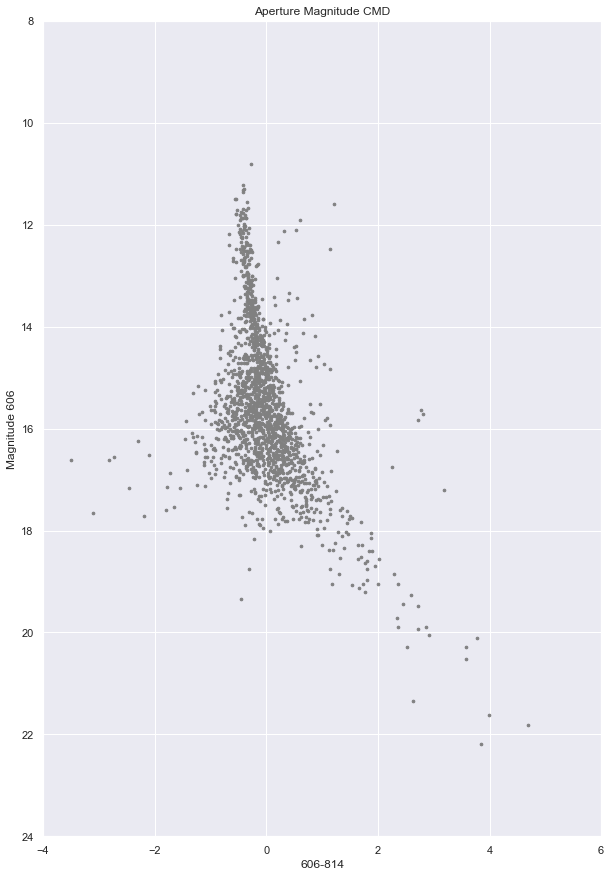

In [14]:
plt.figure(figsize=(10,15))
plt.title('Aperture Magnitude CMD')
plt.xlabel('606-814')
plt.xlim(-4,6)
plt.ylim(8,24)
plt.ylabel('Magnitude 606')
colour = data_astroML['magnitude_ap_606'] - data_astroML['magnitude_ap_814']
plt.scatter(x = colour, y = data_astroML['magnitude_ap_606'], color='grey', s=7)
plt.gca().invert_yaxis()
plt.show()

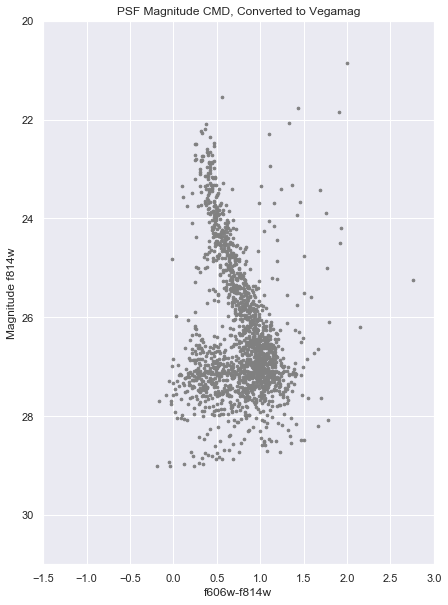

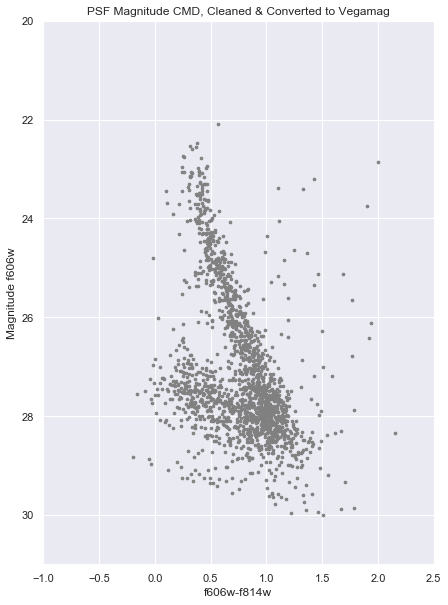

In [15]:
#instrumental aperture, psf magnitudes
ap_instrumental_606 = data_astroML['magnitude_ap_606'] - 25.0 #stetson offset
ap_instrumental_814 = data_astroML['magnitude_ap_814'] - 25.0

als_instrumental_606 = data_astroML['magnitude_als_606'] - 25.0 - 0.088 #aperture corrections
als_instrumental_814 = data_astroML['magnitude_als_814'] - 25.0 - 0.087

#converting aperture instrumental to vegamag, using exptimes from sky correction notebook/image headers, filter zero
#points from hubble website


exptime_606 = 9792.0
exptime_814 = 10064.0

#add aperture correction

M_ap_606 = ap_instrumental_606 + 2.5 * np.log10(exptime_606) + 26.403 #606 vegamag zeropoint
M_ap_814 = ap_instrumental_814 + 2.5 * np.log10(exptime_814) + 25.514  #814 vegamag zeropoint

#M_ap_606 = ap_instrumental_606 + 2.5 * np.log10(exptime_606) + 26.655 #606 stmag zeropoint
#M_ap_814 = ap_instrumental_814 + 2.5 * np.log10(exptime_814) + 26.776 #814 stmag zeropoint

M_psf_606 = als_instrumental_606 + 2.5 * np.log10(exptime_606) + 26.403
M_psf_814 = als_instrumental_814 + 2.5 * np.log10(exptime_814) + 25.514

data_astroML['MAG_psf_f606w'] = M_psf_606
data_astroML['MAG_psf_f814w'] = M_psf_814
data_astroML['MAG_ap_f814w'] = M_ap_814
data_astroML['MAG_ap_f606w'] = M_ap_606


plt.figure(figsize=(7,10))
plt.title('PSF Magnitude CMD, Converted to Vegamag')
plt.xlabel('f606w-f814w')
plt.xlim(-1.5,3)
plt.ylim(20,31)
plt.ylabel('Magnitude f814w')
colour = M_psf_606 - M_psf_814
plt.scatter(x = colour, y = M_psf_814, color='grey', s=7)
plt.gca().invert_yaxis()
plt.savefig('pointing_5_Epoch2_first_round_fixed.png')
plt.show()

plt.figure(figsize=(7,10))
plt.title('PSF Magnitude CMD, Cleaned & Converted to Vegamag')
plt.xlabel('f606w-f814w')
plt.xlim(-1,2.5)
plt.ylim(20, 31)
plt.ylabel('Magnitude f606w')
colour = M_psf_606 - M_psf_814
plt.scatter(x = colour, y = M_psf_606, color='grey', s=7)
plt.gca().invert_yaxis()
plt.show()

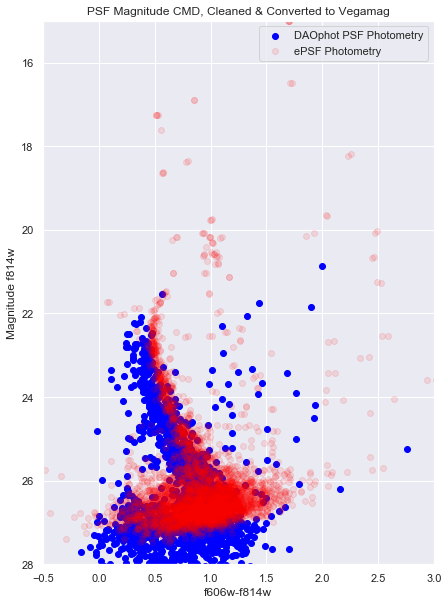

In [17]:
epsf_phot = pd.read_csv('vera_photometry.csv', sep='\s+', header=None, skiprows=2,
                       names=['x', 'y', 'mag_f606w', 'mag_f814w','0','weight_f606w', 'weight_f814w', '0_',
                             '606_error', '814_erorr','0__', 'obs_606','obs_814','0____'])
epsf_phot = epsf_phot.drop(columns=['0','0_','0__','0____'])


plt.figure(figsize=(7,10))
plt.title('PSF Magnitude CMD, Cleaned & Converted to Vegamag')
plt.xlabel('f606w-f814w')
plt.xlim(-0.5, 3)
plt.ylim(15, 28)
plt.ylabel('Magnitude f814w')
colour = M_psf_606 - M_psf_814

plt.scatter(x = colour, y = M_psf_814, color='blue', alpha = 1)

plt.scatter(x= epsf_phot['weight_f606w'] - epsf_phot['weight_f814w'], y = epsf_phot['weight_f814w'], color='red',
            alpha = .1)

plt.gca().invert_yaxis()
plt.legend(['DAOphot PSF Photometry', 'ePSF Photometry'])
#plt.savefig('pointing_5_Epoch2_veraoverplot_CMD.png')
plt.show()

## Doin the same thing but with the results from the second round of allstar - i.e. more stars! Note that we don't clean the data until AFTER it is combined

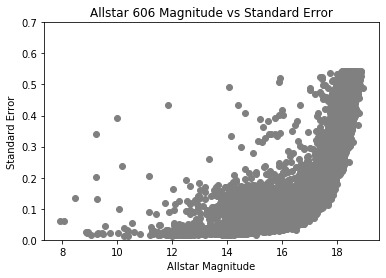

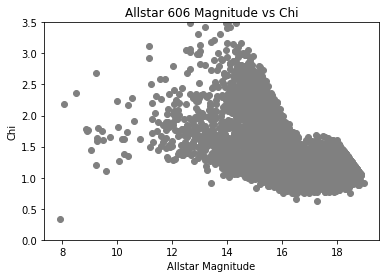

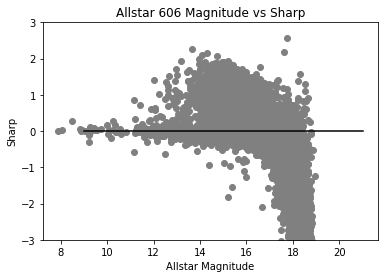

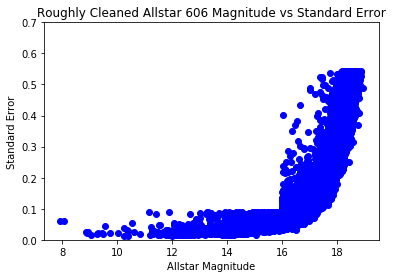

In [2]:
#reading in allstar data
als_data_606 = pd.read_csv('pointing_5_606_mask_sub.als', sep='\s+', header=None, skiprows=2, 
                  names = ['ID', 'x', 'y', 'magnitude', 'standard error', 'sky', 'iterations', 'chi', 'sharp'])
als_data_606 = als_data_606.set_index('ID')
als_data_606_rough_clean = als_data_606[(als_data_606['standard error']< 0.09) & (als_data_606['magnitude']<16) 
                                  | (als_data_606['magnitude']>16)]

plt.title('Allstar 606 Magnitude vs Standard Error')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Standard Error')
plt.ylim(0,.7)
plt.scatter(x = als_data_606['magnitude'], y = als_data_606['standard error'],color='grey')
plt.show()

plt.title('Allstar 606 Magnitude vs Chi')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Chi')
plt.ylim(0,3.5)
plt.scatter(x = als_data_606['magnitude'], y = np.sqrt(als_data_606['chi']), color='grey')
plt.show()

plt.title('Allstar 606 Magnitude vs Sharp')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Sharp')
plt.ylim(-3,3)
plt.scatter(x = als_data_606['magnitude'], y = als_data_606['sharp'], color='grey')
plt.plot([9,21], [0, 0], 'k-')
plt.show()

plt.title('Roughly Cleaned Allstar 606 Magnitude vs Standard Error')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Standard Error')
plt.ylim(0,.7)
plt.scatter(x = als_data_606_rough_clean['magnitude'], y = als_data_606_rough_clean['standard error'],color='blue')
plt.show()


        Use astropy.visualization.hist instead. [warnings]


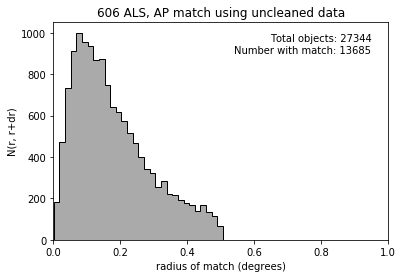

In [3]:
#reading in ap data
ap_data_606 = pd.read_csv('pointing_5_606_mask.cmb', sep='\s+', header=None, skiprows=2, 
                  names = ['ID', 'x', 'y', 'magnitude', 'sky'])

#doing a crossmatch with astroML, note that I can no longer match on ID bc non-uniqueness etc
import numpy as np
from matplotlib import pyplot as plt
from astroML.crossmatch import crossmatch
from astroML.plotting import hist


#this is cleaned !
# defining an array that's len(data_606) x 2 then putting the x, y data into it 

#NOTE !!!! we are using the ap locations as these are NOT recentred so they should line up exactly
imX = np.empty((len(ap_data_606), 2), dtype=np.float64)
imX[:, 0] = ap_data_606['x']
imX[:, 1] = ap_data_606['y']

# defining an array that's len(data_814) x 2 then putting the x, y data into it 
stX = np.empty((len(als_data_606), 2), dtype=np.float64)
stX[:, 0] = als_data_606['x']
stX[:, 1] = als_data_606['y']




# crossmatch catalogs using https://www.astroml.org/book_figures/chapter6/fig_stellar_XD.html
max_radius = .5  # the # of maximum degrees in separation
dist, ind = crossmatch(imX, stX, max_radius)
match = (~np.isinf(dist))
dist_match = dist[match]
match_ind = ind[match]




ax = plt.axes()
hist(dist_match, ax=ax, bins='scott',#bins='knuth', ax=ax,
     histtype='stepfilled', ec='k', fc='#AAAAAA')
ax.set_xlabel('radius of match (degrees)')
ax.set_ylabel('N(r, r+dr)')
ax.text(0.95, 0.95,
        "Total objects: %i\nNumber with match: %i" % (imX.shape[0],
                                                      np.sum(match)),
        ha='right', va='top', transform=ax.transAxes)
ax.set_xlim(0, 1)
plt.title('606 ALS, AP match using uncleaned data')
plt.show()

matched_ap = ap_data_606[match].reset_index()
matched_als = als_data_606.iloc[match_ind].reset_index()

data_606 = pd.merge(matched_ap, matched_als, how='inner', left_index=True, 
                        right_index=True, suffixes=['_ap','_als'])
data_606 = data_606[data_606['magnitude_ap']<99]

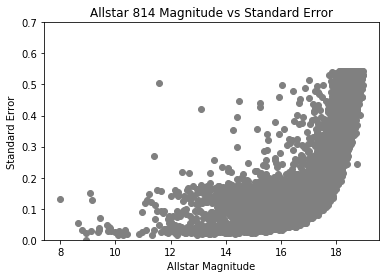

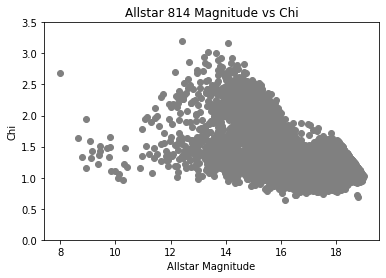

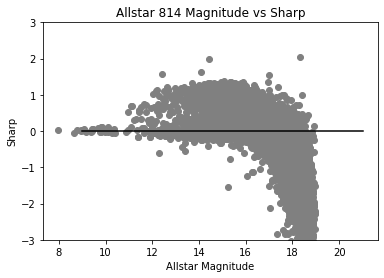

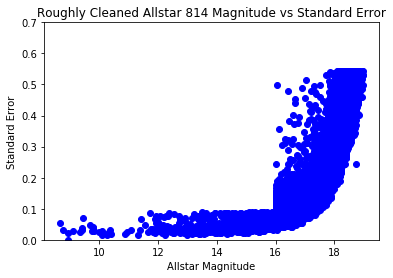

In [4]:
#reading in allstar data for 814
als_data_814 = pd.read_csv('pointing_5_814_mask_sub.als', sep='\s+', header=None, skiprows=2, 
                  names = ['ID', 'x', 'y', 'magnitude', 'standard error', 'sky', 'iterations', 'chi', 'sharp'])
als_data_814 = als_data_814.set_index('ID')
als_data_814_rough_clean = als_data_814[(als_data_814['standard error']< .09) & (als_data_814['magnitude']<16.) 
                                  | (als_data_814['magnitude']>16.)]

plt.title('Allstar 814 Magnitude vs Standard Error')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Standard Error')
plt.ylim(0,.7)
plt.scatter(x = als_data_814['magnitude'], y = als_data_814['standard error'],color='grey')
plt.show()

plt.title('Allstar 814 Magnitude vs Chi')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Chi')
plt.ylim(0,3.5)
plt.scatter(x = als_data_814['magnitude'], y = np.sqrt(als_data_814['chi']), color='grey')
plt.show()

plt.title('Allstar 814 Magnitude vs Sharp')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Sharp')
plt.ylim(-3,3)
plt.scatter(x = als_data_814['magnitude'], y = als_data_814['sharp'], color='grey')
plt.plot([9,21], [0, 0], 'k-')
plt.show()

plt.title('Roughly Cleaned Allstar 814 Magnitude vs Standard Error')
plt.xlabel('Allstar Magnitude')
plt.ylabel('Standard Error')
plt.ylim(0,.7)
plt.scatter(x = als_data_814_rough_clean['magnitude'], y = als_data_814_rough_clean['standard error'],color='blue')
plt.show()

        Use astropy.visualization.hist instead. [warnings]


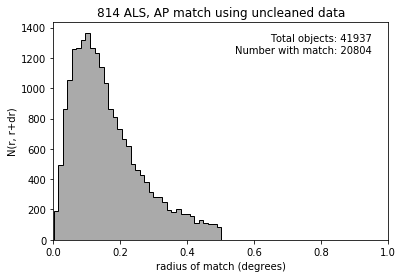

In [5]:
#reading in ap data
ap_data_814 = pd.read_csv('pointing_5_814_mask.cmb', sep='\s+', header=None, skiprows=2, 
                  names = ['ID', 'x', 'y', 'magnitude', 'sky'])

#doing a crossmatch with astroML, note that I can no longer match on ID bc non-uniqueness etc
import numpy as np
from matplotlib import pyplot as plt
from astroML.crossmatch import crossmatch
from astroML.plotting import hist


#this is cleaned !
# defining an array that's len(data_606) x 2 then putting the x, y data into it 

#NOTE !!!! we are using the ap locations as these are NOT recentred so they should line up exactly
imX = np.empty((len(ap_data_814), 2), dtype=np.float64)
imX[:, 0] = ap_data_814['x']
imX[:, 1] = ap_data_814['y']

# defining an array that's len(data_814) x 2 then putting the x, y data into it 
stX = np.empty((len(als_data_814), 2), dtype=np.float64)
stX[:, 0] = als_data_814['x']
stX[:, 1] = als_data_814['y']




# crossmatch catalogs using https://www.astroml.org/book_figures/chapter6/fig_stellar_XD.html
max_radius = .5  # the # of maximum degrees in separation
dist, ind = crossmatch(imX, stX, max_radius)
match = (~np.isinf(dist))
dist_match = dist[match]
match_ind = ind[match]




ax = plt.axes()
hist(dist_match, ax=ax, bins='scott',#bins='knuth', ax=ax,
     histtype='stepfilled', ec='k', fc='#AAAAAA')
ax.set_xlabel('radius of match (degrees)')
ax.set_ylabel('N(r, r+dr)')
ax.text(0.95, 0.95,
        "Total objects: %i\nNumber with match: %i" % (imX.shape[0],
                                                      np.sum(match)),
        ha='right', va='top', transform=ax.transAxes)
ax.set_xlim(0, 1)
plt.title('814 ALS, AP match using uncleaned data')
plt.show()

matched_ap = ap_data_814[match].reset_index()
matched_als = als_data_814.iloc[match_ind].reset_index()

data_814 = pd.merge(matched_ap, matched_als, how='inner', left_index=True, 
                        right_index=True, suffixes=['_ap','_als'])
data_814= data_814[data_814['magnitude_ap']<99]

        Use astropy.visualization.hist instead. [warnings]


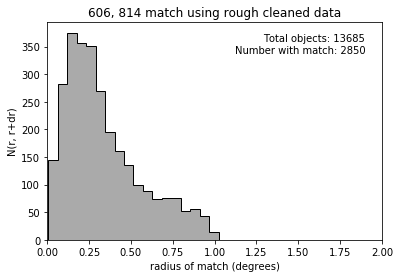

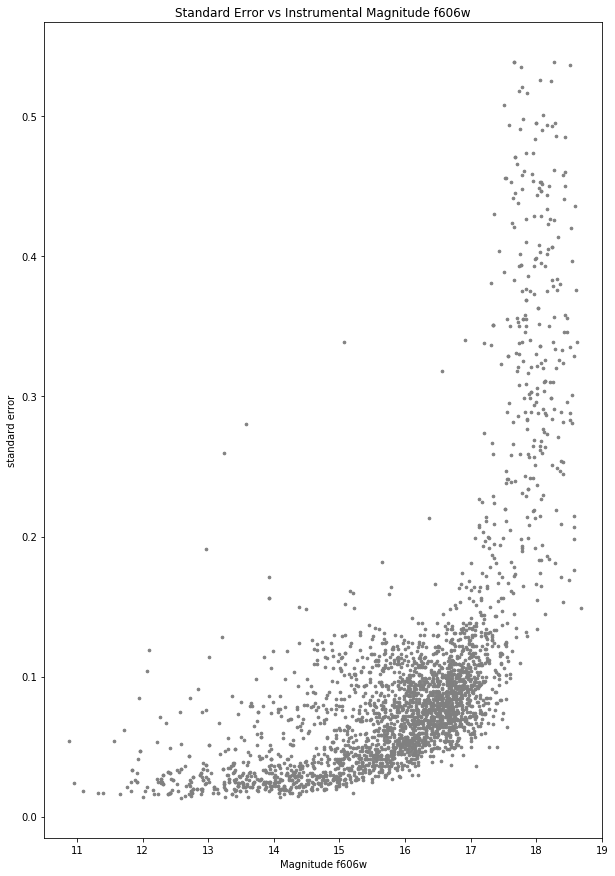

In [6]:
#exporting to csv files so that I can use topcat to cross match! 
data_606.to_csv('data_606.csv', encoding='utf-8', index=False)
data_814.to_csv('data_814.csv', encoding='utf-8', index=False)

#data_topcat = pd.read_csv('data') #seeing cross match from topcat



#doing a crossmatch with astroML, good sanity check that these are the same
import numpy as np
from matplotlib import pyplot as plt
from astroML.crossmatch import crossmatch
from astroML.plotting import hist


#this is cleaned !
# defining an array that's len(data_606) x 2 then putting the x, y data into it 

#NOTE !!!! we are using the ap locations as these are NOT recentred so they should line up more closely (?)
imX = np.empty((len(data_606), 2), dtype=np.float64)
imX[:, 0] = data_606['x_als']
imX[:, 1] = data_606['y_als']

# defining an array that's len(data_814) x 2 then putting the x, y data into it 
stX = np.empty((len(data_814), 2), dtype=np.float64)
stX[:, 0] = data_814['x_als']
stX[:, 1] = data_814['y_als']




# crossmatch catalogs using https://www.astroml.org/book_figures/chapter6/fig_stellar_XD.html
max_radius = 1 # the # of maximum degrees in separation
dist, ind = crossmatch(imX, stX, max_radius)
match = (~np.isinf(dist))
dist_match = dist[match]
match_ind = ind[match]




ax = plt.axes()
hist(dist_match, ax=ax, bins='scott',#bins='knuth', ax=ax,
     histtype='stepfilled', ec='k', fc='#AAAAAA')
ax.set_xlabel('radius of match (degrees)')
ax.set_ylabel('N(r, r+dr)')
ax.text(0.95, 0.95,
        "Total objects: %i\nNumber with match: %i" % (imX.shape[0],
                                                      np.sum(match)),
        ha='right', va='top', transform=ax.transAxes)
ax.set_xlim(0, 2)
plt.title('606, 814 match using rough cleaned data')
plt.show()

matched_606 = data_606[match].reset_index()
matched_814 = data_814.iloc[match_ind].reset_index()

data_astroML = pd.merge(matched_606, matched_814, how='inner', left_index=True, 
                        right_index=True, suffixes=['_606','_814'])

plt.figure(figsize=(10,15))
plt.title('Standard Error vs Instrumental Magnitude f606w')
plt.xlabel('Magnitude f606w')
plt.ylabel('standard error')
plt.xlim(10.5, 19)
plt.scatter(x = data_astroML['magnitude_als_814'], y = data_astroML['standard error_606'], color='grey', s=7)
plt.show()

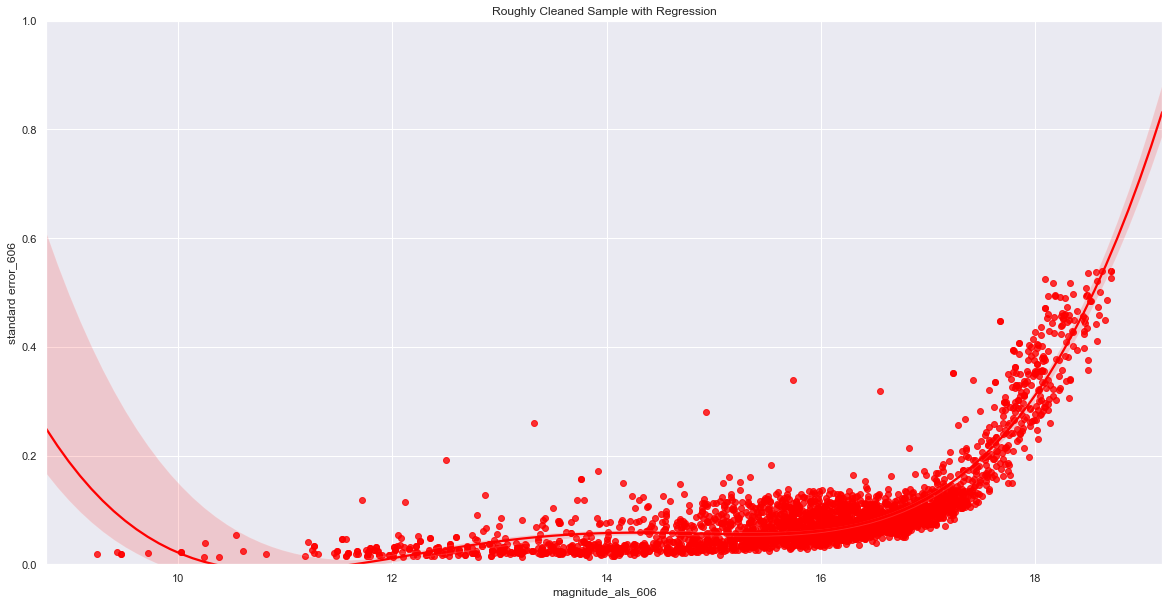

R^2 coefficient 0.8564848361205885
coefficients: [[ 2.49633679e+01 -3.89208874e+00  3.00346832e-01 -1.14773498e-02
   1.73890579e-04]]


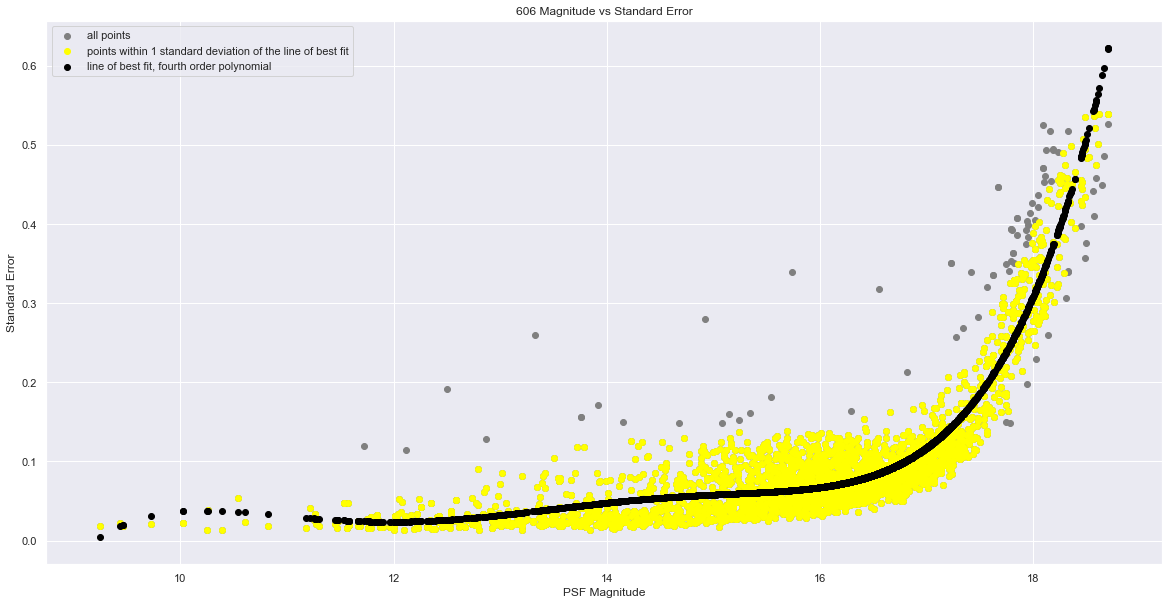

regression line standard deviation is:


0.0844717557086232

In [7]:
#attempting to get a line of best fit to then define quality cuts off of - note that I need to make the crude cut 
#above first to avoid having the noisey/bad data weight the fit, this way i fit only the ~good~ data

#http://seaborn.pydata.org/generated/seaborn.regplot.html?highlight=regplot#seaborn.regplot


#doing this first with 606, then 814 in next cell
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(20,10))
plt.title('Roughly Cleaned Sample with Regression')
plt.ylim(0,1)
ax = sns.regplot(x="magnitude_als_606", y="standard error_606", data=data_astroML, color='red', 
                 order=4, fit_reg=True,ci=100)
plt.show()


#following this to get equation of regression line https://realpython.com/linear-regression-in-python/ 
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
x=data_astroML["magnitude_als_606"]
y = data_astroML['standard error_606']

x = np.array([x]).reshape(-1,1)
x_ = PolynomialFeatures(degree=5, include_bias=False).fit_transform(x) #getting it so that it will do polynomial
#order five fit
y = np.array([y]).reshape(-1,1)
model = LinearRegression().fit(x_, y)
r_sq = model.score(x_, y)
coefficients = model.coef_
print('R^2 coefficient',r_sq)
print('coefficients:', model.coef_)

#equation of our regression line for 606
x = data_astroML['magnitude_als_606']
y = data_astroML['standard error_606']

regression_line = np.array([coefficients[:,0]*x**1 + coefficients[:,1]*x**2 + coefficients[:,2]*x**3 + 
                            coefficients[:,3]*x**4 + coefficients[:,4]*x**5 +
                            model.intercept_]).reshape(len(x),)


#cutting data using buffer around regression line
data_astroML_clean = data_astroML[(y < regression_line + regression_line.std()) & 
                                  (y > regression_line - regression_line.std())]

#data_astroML_clean = data_astroML[(y < 1.682*regression_line) & (y > 0.318*regression_line)]


plt.figure(figsize=(20,10))
plt.title('606 Magnitude vs Standard Error')
plt.scatter(x, y, color='grey')
plt.scatter(data_astroML_clean['magnitude_als_606'], data_astroML_clean['standard error_606'], 
            color='yellow',marker='o')
plt.scatter(x, regression_line, color='black')
plt.legend(['all points', 'points within 1 standard deviation of the line of best fit',
            'line of best fit, fourth order polynomial'])
plt.ylabel('Standard Error')
plt.xlabel('PSF Magnitude')
plt.show()


print('regression line standard deviation is:')
regression_line.std()

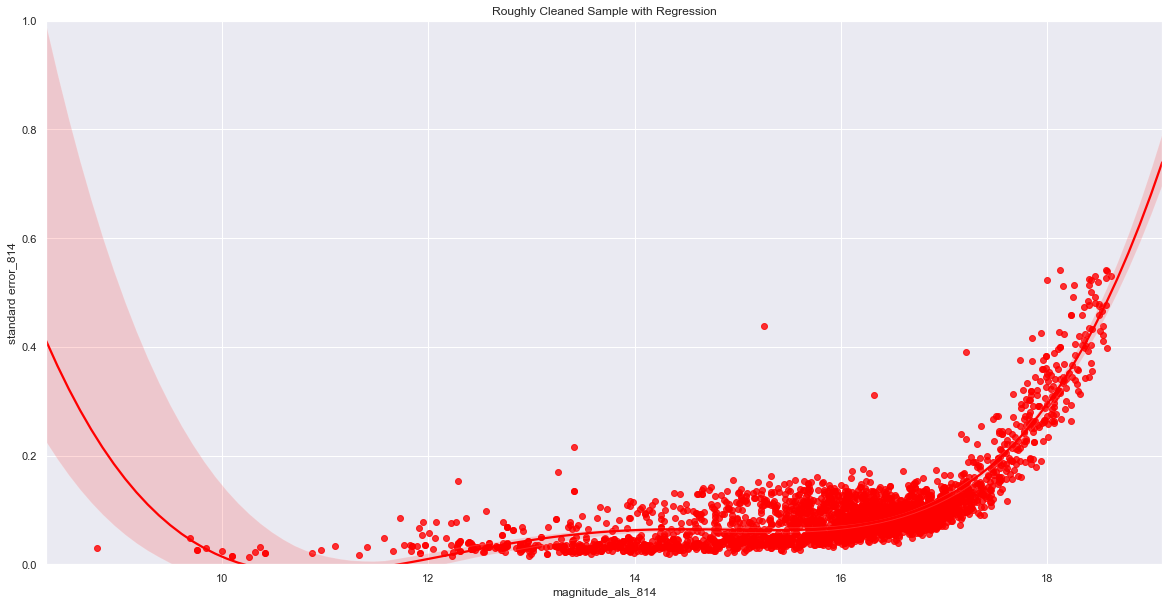

R^2 coefficient 0.8238072150266386
coefficients: [[ 3.07222846e+01 -4.74260648e+00  3.62041117e-01 -1.36765285e-02
   2.04720950e-04]]


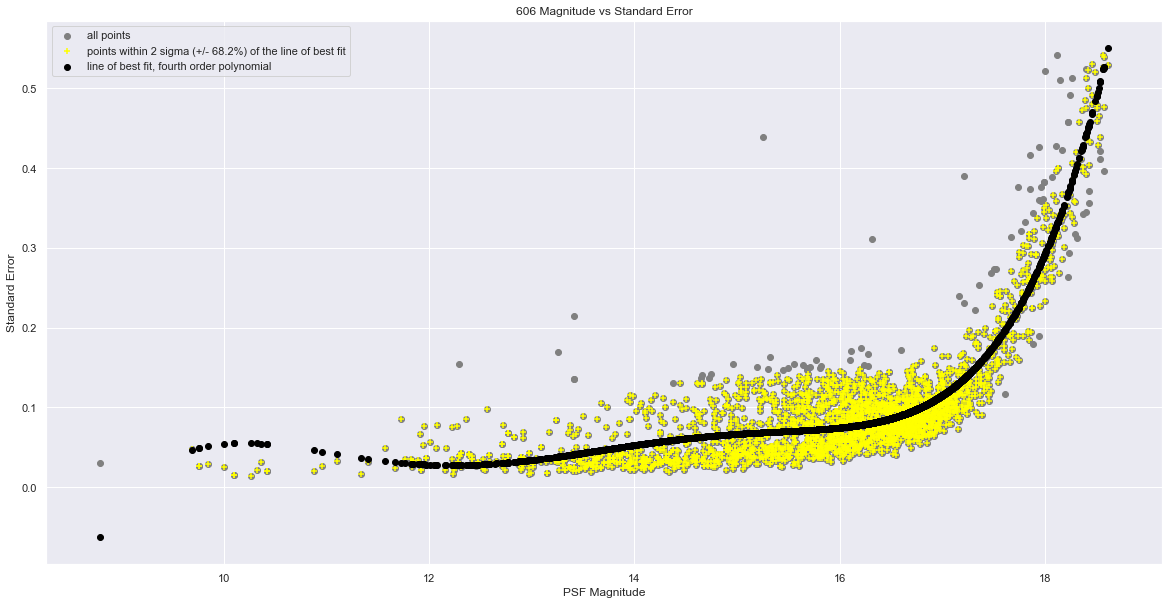

std of regression line is:


0.07176779873242708

In [8]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(20,10))
plt.title('Roughly Cleaned Sample with Regression')
plt.ylim(0,1)
ax = sns.regplot(x="magnitude_als_814", y="standard error_814", data=data_astroML_clean, 
                 color='red', order=4, fit_reg=True,
                 ci=100)
plt.show()


#following this to get equation of regression line https://realpython.com/linear-regression-in-python/ 
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
x=data_astroML_clean["magnitude_als_814"]
y = data_astroML_clean['standard error_814']

x = np.array([x]).reshape(-1,1)
x_ = PolynomialFeatures(degree=5, include_bias=False).fit_transform(x) #getting it so that it will do polynomial
#order five fit
y = np.array([y]).reshape(-1,1)
model = LinearRegression().fit(x_, y)
r_sq = model.score(x_, y)
coefficients = model.coef_
print('R^2 coefficient',r_sq)
print('coefficients:', model.coef_)

#equation of our regression line for 814
x = data_astroML_clean['magnitude_als_814']
y = data_astroML_clean['standard error_814']

regression_line = np.array([coefficients[:,0]*x**1 + coefficients[:,1]*x**2 + coefficients[:,2]*x**3 + 
                            coefficients[:,3]*x**4 + coefficients[:,4]*x**5 + model.intercept_]).reshape(len(x),)


#cutting data using buffer around regression line
#data_astroML_clean = data_astroML_clean[(y < 1.682*regression_line) & (y > 0.318*regression_line)]

data_astroML_clean = data_astroML_clean[(y < regression_line + regression_line.std()) & 
                                  (y > regression_line - regression_line.std())]


plt.figure(figsize=(20,10))
plt.title('606 Magnitude vs Standard Error')
plt.scatter(x, y, color='grey')
plt.scatter(data_astroML_clean['magnitude_als_814'], data_astroML_clean['standard error_814'], 
            color='yellow',marker='+')
plt.scatter(x, regression_line, color='black')
plt.legend(['all points', 'points within 2 sigma (+/- 68.2%) of the line of best fit',
            'line of best fit, fourth order polynomial'])
plt.ylabel('Standard Error')
plt.xlabel('PSF Magnitude')
plt.show()

print('std of regression line is:')
regression_line.std()

In [9]:
#cleaning up our data file, which is 1246 rows long, btw
data_astroML = data_astroML.drop(columns=['level_0_606', 'index_606', 'ID_ap_606', 
                                                      'ID_als_606', 'ID_ap_606','level_0_814', 
                                                      'index_814', 'ID_ap_814', 'ID_als_814', 'ID_ap_814',
                                                      'sky_ap_814', 'sky_ap_606', 'iterations_606', 'iterations_814'])

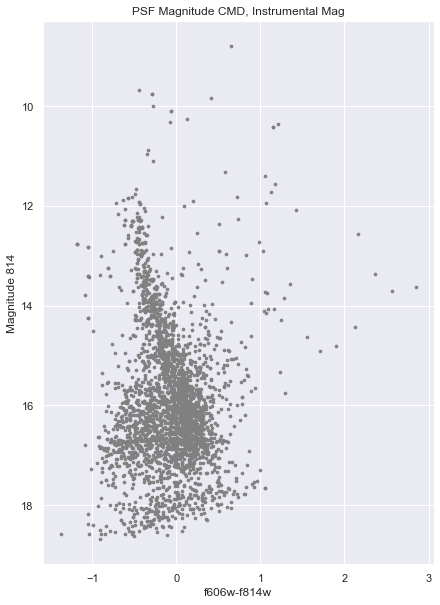

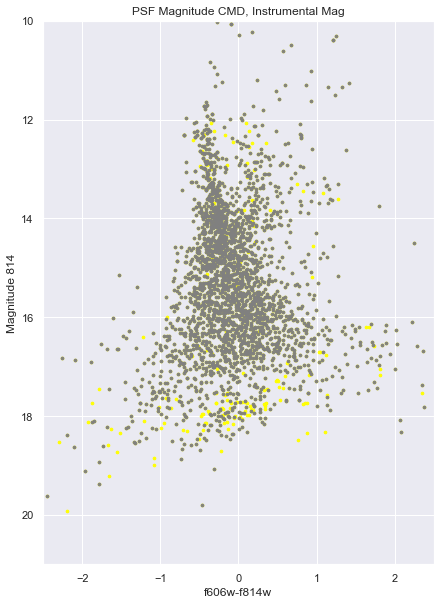

In [10]:
#quick pre-conversion CMD
plt.figure(figsize=(7,10))
plt.title('PSF Magnitude CMD, Instrumental Mag')
plt.xlabel('f606w-f814w')
#plt.xlim(-1,2.5)
#plt.ylim(18, 29)
plt.ylabel('Magnitude 814')
colour = data_astroML['magnitude_als_606'] - data_astroML['magnitude_als_814']
plt.scatter(x = colour, y = data_astroML['magnitude_als_814'], color='grey', s=7)
plt.gca().invert_yaxis()
plt.show()

#quick pre-conversion CMD
plt.figure(figsize=(7,10))
plt.title('PSF Magnitude CMD, Instrumental Mag')
plt.xlabel('f606w-f814w')
plt.xlim(-2.5,2.5)
plt.ylim(10, 21)
plt.ylabel('Magnitude 814')
colour = data_astroML_clean['magnitude_ap_606'] - data_astroML_clean['magnitude_ap_814']
plt.scatter(x = data_astroML['magnitude_ap_606'] - data_astroML['magnitude_ap_814'], 
            y = data_astroML['magnitude_ap_814'], color='yellow', s=7)
plt.scatter(x = colour, y = data_astroML_clean['magnitude_ap_814'], color='grey', s=7)

plt.gca().invert_yaxis()
plt.show()

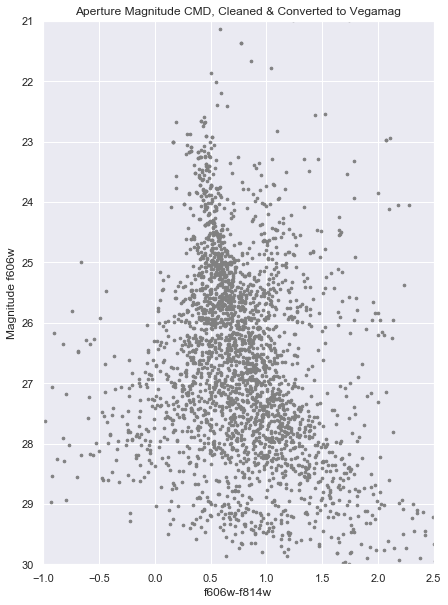

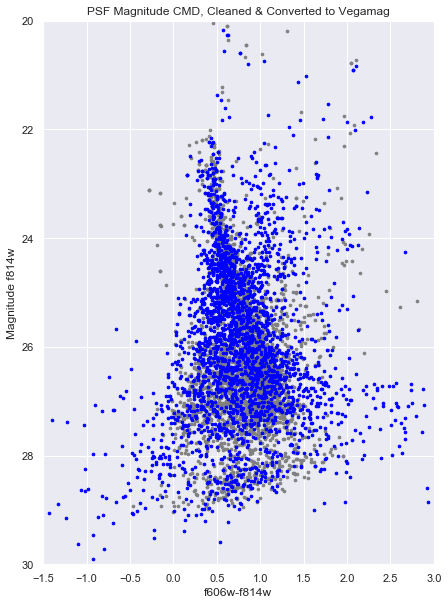

In [11]:
#converting magnitudes


#instrumental aperture, psf magnitudes
ap_instrumental_606 = data_astroML['magnitude_ap_606'] - 25.0 #stetson offset
ap_instrumental_814 = data_astroML['magnitude_ap_814'] - 25.0

als_instrumental_606 = data_astroML['magnitude_als_606'] - 25.0 - 0.088 #aperture corrections
als_instrumental_814 = data_astroML['magnitude_als_814'] - 25.0 - 0.087

#converting aperture instrumental to vegamag, using exptimes from sky correction notebook/image headers, filter zero
#points from hubble website

#exptime_606 = 7344.0
#exptime_814 = 7548.0

exptime_606 = 9792.0
exptime_814 = 10064.0

#add aperture correction

M_ap_606 = ap_instrumental_606 + 2.5 * np.log10(exptime_606) + 26.403 #606 vegamag zeropoint
M_ap_814 = ap_instrumental_814 + 2.5 * np.log10(exptime_814) + 25.514  #814 vegamag zeropoint

#M_ap_606 = ap_instrumental_606 + 2.5 * np.log10(exptime_606) + 26.655 #606 stmag zeropoint
#M_ap_814 = ap_instrumental_814 + 2.5 * np.log10(exptime_814) + 26.776 #814 stmag zeropoint

#converting psf to vegamag

M_psf_606 = als_instrumental_606 + 2.5 * np.log10(exptime_606) + 26.403 -0.045 + .008 #- 0.085 #psf-ap corr
M_psf_814 = als_instrumental_814 + 2.5 * np.log10(exptime_814) + 25.514 -.09 + .008 #- 0.09 #psf - ap corr

data_astroML['MAG_psf_f606w'] = M_psf_606
data_astroML['MAG_psf_f814w'] = M_psf_814
data_astroML['MAG_ap_f814w'] = M_ap_814
data_astroML['MAG_ap_f606w'] = M_ap_606


plt.figure(figsize=(7,10))
plt.title('Aperture Magnitude CMD, Cleaned & Converted to Vegamag')
plt.xlabel('f606w-f814w')
plt.xlim(-1,2.5)
plt.ylim(21,30)
plt.ylabel('Magnitude f606w')
colour = M_ap_606 - M_ap_814
plt.scatter(x = colour, y = M_ap_606, color='grey', s=7)
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(7,10))
plt.title('PSF Magnitude CMD, Cleaned & Converted to Vegamag')
plt.xlabel('f606w-f814w')
plt.xlim(-1.5,3)
plt.ylim(20, 30)
plt.ylabel('Magnitude f814w')
colour = M_psf_606 - M_psf_814
colour_1 = M_ap_606 - M_ap_814
plt.scatter(x = colour, y = M_psf_814, color='grey', s=7)
plt.scatter(x = colour_1, y = M_ap_814, color='blue', s=7)
plt.gca().invert_yaxis()
plt.savefig('pointing_5_Epoch2_second_round_CMD.png')
plt.show()

(-0.2, 0.2)

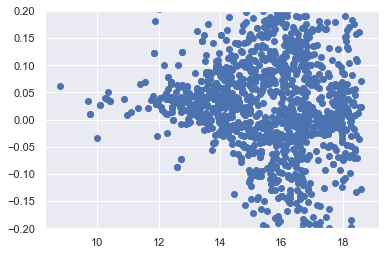

In [12]:
plt.scatter(data_astroML['magnitude_als_814'], data_astroML['magnitude_als_814'] - data_astroML['magnitude_ap_814'])
plt.ylim(-.2, .2)

In [14]:
data_astroML_trimmed = data_astroML[(data_astroML['standard error_606']<=.2)
                                    & (data_astroML['standard error_814']<=.2)
                                  # & (data_astroML['sharp_814']<=.5)
                                  #& (data_astroML['sharp_814']>=-.5)
                                   #& (data_astroML['sharp_606']<=.5)
                                   #& (data_astroML['sharp_606']>=-.5)
                                   &(data_astroML['magnitude_als_606'] - data_astroML['magnitude_ap_606']<=1)
                                   &(data_astroML['magnitude_als_606'] - data_astroML['magnitude_ap_606']>=-1)
                                   &(data_astroML['magnitude_als_814'] - data_astroML['magnitude_ap_814']<=1)
                                   &(data_astroML['magnitude_als_814'] - data_astroML['magnitude_ap_814']>=-1)]

total_selected_606 = np.array([])
total_selected_814 = np.array([])
for i in np.arange(100):
    selected = data_astroML_trimmed.sample(100)
    selected_median_606 = (selected['magnitude_als_606'] - selected['magnitude_ap_606']).median()
    selected_median_814 = (selected['magnitude_als_814'] - selected['magnitude_ap_814']).median()
    total_selected_606=np.append(total_selected_606,selected_median_606) 
    total_selected_814=np.append(total_selected_814,selected_median_814)
total_selected_606.mean(),total_selected_814.mean(),(data_astroML_trimmed['magnitude_als_606'] - data_astroML_trimmed['magnitude_ap_606']).describe(),(data_astroML_trimmed['magnitude_als_814'] - data_astroML_trimmed['magnitude_ap_814']).describe()

(0.05490000000000013, 0.08652000000000007, count    1801.000000
 mean        0.154522
 std         0.347929
 min        -0.990000
 25%        -0.037000
 50%         0.046000
 75%         0.386000
 max         0.995000
 dtype: float64, count    1801.000000
 mean        0.177181
 std         0.332829
 min        -0.982000
 25%        -0.005000
 50%         0.084000
 75%         0.393000
 max         0.999000
 dtype: float64)

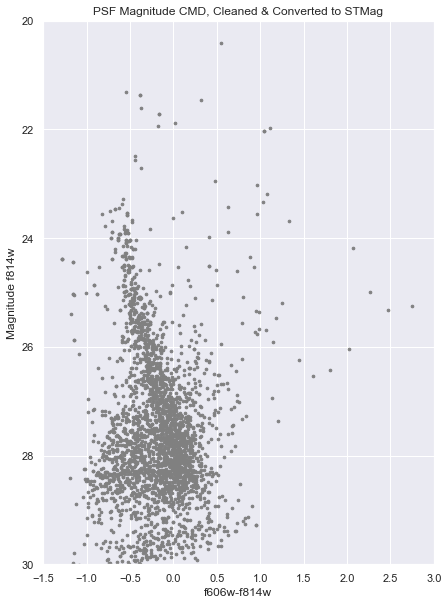

In [15]:
#stmag conversion
M_ap_606_stmag = ap_instrumental_606 + 2.5 * np.log10(exptime_606) + 26.666 #606 stmag zeropoint
M_ap_814_stmag = ap_instrumental_814 + 2.5 * np.log10(exptime_814) + 26.778 #814 stmag zeropoint

#converting psf to vegamag


M_psf_606_stmag = als_instrumental_606 + 2.5 * np.log10(exptime_606) + 26.666 - 0.045 +.008 #psf-ap corr
M_psf_814_stmag = als_instrumental_814 + 2.5 * np.log10(exptime_814) + 26.778 - 0.09 + 0.008#ap corr

data_astroML['MAG_psf_f606w_stmag'] = M_psf_606_stmag
data_astroML['MAG_psf_f814w_stmag'] = M_psf_814_stmag

plt.figure(figsize=(7,10))
plt.title('PSF Magnitude CMD, Cleaned & Converted to STMag')
plt.xlabel('f606w-f814w')
plt.xlim(-1.5,3)
plt.ylim(20, 30)
plt.ylabel('Magnitude f814w')
colour = M_psf_606_stmag - M_psf_814_stmag
plt.scatter(x = colour, y = M_psf_814_stmag, color='grey', s=7)
plt.gca().invert_yaxis()
#plt.savefig('pointing_5_Epoch2_second_round_CMD.png')
plt.show()

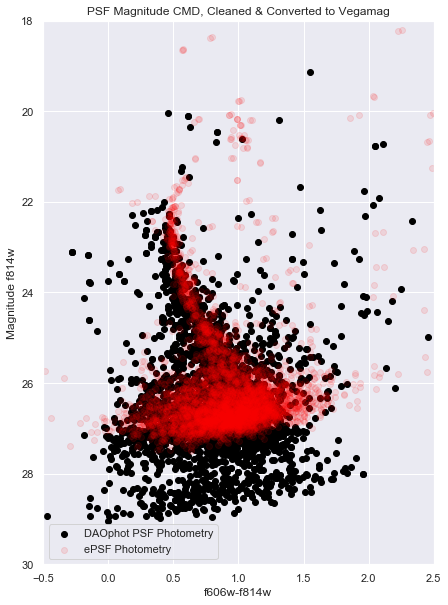

In [55]:
#overplotting Vera's cmd
epsf_phot = pd.read_csv('vera_photometry.csv', sep='\s+', header=None, skiprows=2,
                       names=['x', 'y', 'mag_f606w', 'mag_f814w','0','weight_f606w', 'weight_f814w', '0_',
                             '606_error', '814_erorr','0__', 'obs_606','obs_814','0____'])
epsf_phot = epsf_phot.drop(columns=['0','0_','0__','0____'])


plt.figure(figsize=(7,10))
plt.title('PSF Magnitude CMD, Cleaned & Converted to Vegamag')
plt.xlabel('f606w-f814w')
plt.xlim(-0.5, 2.5)
plt.ylim(18, 30)
plt.ylabel('Magnitude f814w')
colour = M_psf_606 - M_psf_814

plt.scatter(x = colour, y = M_psf_814, color='black', alpha = 1)

plt.scatter(x= epsf_phot['weight_f606w'] - epsf_phot['weight_f814w'], y = epsf_phot['weight_f814w'], color='red',
            alpha = .1)

plt.gca().invert_yaxis()
plt.legend(['DAOphot PSF Photometry', 'ePSF Photometry'])
plt.savefig('pointing_5_Epoch2_veraoverplot_CMD.png')
plt.show()


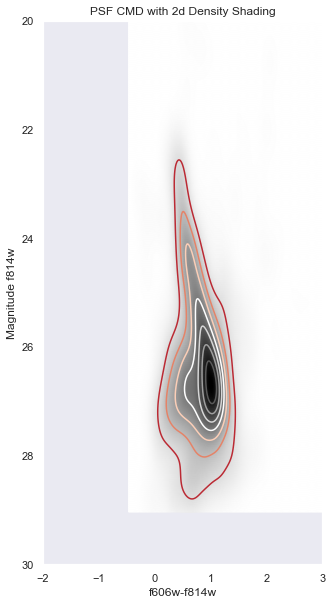

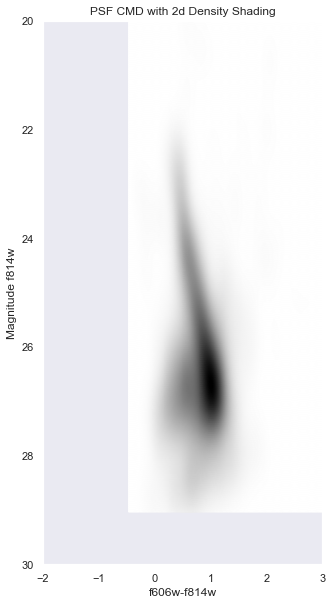

<Figure size 432x288 with 0 Axes>

In [56]:
from scipy.stats import kde
x = M_psf_606 - M_psf_814
y = M_psf_814
k = kde.gaussian_kde(np.array([x,y]))
nbins = 250

xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))


plt.figure(figsize=(5,10))
plt.title('PSF CMD with 2d Density Shading')
plt.xlabel('f606w-f814w')
plt.ylabel('Magnitude f814w')
plt.xlim(-2, 3)
plt.ylim(20,30)
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap='binary')#cmap=plt.cm.BuGn_r)
plt.contour(xi, yi, zi.reshape(xi.shape), cmap='RdGy')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(5,10))
plt.title('PSF CMD with 2d Density Shading')
plt.xlabel('f606w-f814w')
plt.ylabel('Magnitude f814w')
plt.xlim(-2, 3)
plt.ylim(20,30)
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap='binary')#cmap=plt.cm.BuGn_r)
#plt.contour(xi, yi, zi.reshape(xi.shape), cmap='RdGy')
plt.gca().invert_yaxis()
plt.show()
plt.savefig('pointing_5_Epoch2_density_CMD.png')

In [57]:
#exporting files to overplot
data_astroML_clean.to_csv('combined_clean_.coo', index=False, encoding='utf-8', sep='\t')
data_814 = data_814.drop(columns=['index','ID_ap'])
data_814.to_csv('data_814.coo', index=False, encoding='utf-8', sep='\t')

In [58]:
#send vera daophot photometry

In [59]:
data_astroML.to_csv('pointing_5_E2.csv', encoding='utf-8', index=False)